#purpose of the project
In this project using Boston Airbnb downloaded from Kaggle site https://www.kaggle.com/datasets/airbnb/boston, I would like to answer following questions.
1. What factors affect pricing of the properties?
2. Are there any areas which have higher prices?
3. Besides usual predictor such as number of bedrooms, are there any interesting observations?

#preparation
Importing necessary libraries and loading data into a dataframe.

In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./data/listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


Define clean_data function to clean data. I skipped descriptive columns which requires NLP. However, amenities such as TV, Internet, AC and free parking are deemed important for pricing; therefore, those are extracted into boolean columns. Also, occupancy is calculated from availabiity_30 column, which should be also an important factor for pricing. Numerical columns were imputed with means. Futhermore, other categorical columns were also converted into one hot encoding.

In [345]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no price
    2. Create X as all the columns that are not the availability columns and that are categorical/quantiative which requires NLP 
    3. Create y as the occupancy rate next 30 days calculated from availability_30
    4. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing availability values
    df = df.dropna(subset=['price'], axis=0)
    
    # from amenities (TV, internet, AC, free parking) are extracted  
    
    TV = []
    Internet = []
    AC = []
    free_parking = []
    
    df_amenities = df['amenities']

    for index, val in df_amenities.items():
        if 'TV' in str(val):
            TV.append('True')
        else:
            TV.append('False')
        
        if 'Internet' in str(val):
            Internet.append('True')
        else:
            Internet.append('False')
        
        if 'Air Conditioning' in str(val):
            AC.append('True')
        else:
            AC.append('False')
        
        if 'Free Parking' in str(val):
            free_parking.append('True')
        else:
            free_parking.append('False')
        
    
    df1 = pd.DataFrame(list(zip(TV, Internet, AC, free_parking)),
                       columns =['TV', 'Internet', 'AC', 'free_parking'])
    
    
    df = df[['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', \
             'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', \
             'bedrooms', 'beds', 'bed_type', 'square_feet', 'price', 'security_deposit', 'cleaning_fee', \
             'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', \
             'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',\
             'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', "availability_30",\
             'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'reviews_per_month']]

    
    df = pd.concat([df, df1], axis=1)
    

    # security deposit and cleaning_fee must be imputed with 0 rather than mean value
    
    for col in ['security_deposit', 'cleaning_fee']:
        df[col].fillna('$0', inplace=True)

    
    # values starting $ should be converted into numeric values
    
    df['price'] = df['price'].str.replace('$', '').str.replace(',', '')
    df['price'] = pd.to_numeric(df['price'])
    
    df['security_deposit'] = df['security_deposit'].str.replace('$', '').str.replace(',', '')
    df['security_deposit'] = pd.to_numeric(df['security_deposit'])
    
    df['cleaning_fee'] = df['cleaning_fee'].str.replace('$', '').str.replace(',', '')
    df['cleaning_fee'] = pd.to_numeric(df['cleaning_fee'])
    
    
    df['extra_people'] = df['extra_people'].str.replace('$', '').str.replace(',', '')
    df['extra_people'] = pd.to_numeric(df['extra_people'])
    
    
    
    # values ending % should be converted into numeric values
    
    
    df['host_response_rate'] = df['host_response_rate'].str.replace('%', '')
    df['host_response_rate'] = pd.to_numeric(df['host_response_rate'])
    
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '')
    df['host_acceptance_rate'] = pd.to_numeric(df['host_acceptance_rate'])
    
    
    # availability_30
    
    df["occupancy"] = df["availability_30"].apply(lambda x: 1-x/30)
    df =df.drop(columns=["availability_30"], axis=1)

    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df.drop(columns=["price"], axis=1)
    y = df["price"]
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df)

<ipython-input-345-4d54441a5ca9>:75: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('$', '').str.replace(',', '')
<ipython-input-345-4d54441a5ca9>:78: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['security_deposit'] = df['security_deposit'].str.replace('$', '').str.replace(',', '')
<ipython-input-345-4d54441a5ca9>:81: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['cleaning_fee'] = df['cleaning_fee'].str.replace('$', '').str.replace(',', '')
<ipython-input-345-4d54441a5ca9>:85: Fut

Data was split into test and train as follows. Linear model was first created. However, this model does not seem alright. We need something better.

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test)

print("The r-squared score for the test model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))
rmse = mean_squared_error(y_test, y_test_preds, squared=False)
print("RMSE of the base model: {}", rmse)


The r-squared score for the test model was -1.2855529833427669e+25 on 1076 values.
RMSE of the base model: {} 606597861038457.5


Allthough test does not seem ok, trainig looks fine.

In [347]:
y_train_preds = lm_model.predict(X_train) 
print("The r-squared score for the train model was {} on {} values.".format(r2_score(y_train, y_train_preds), len(y_test)))
rmse = mean_squared_error(y_train, y_train_preds, squared=False)
print("RMSE of the base train model: {}", rmse)


The r-squared score for the train model was 0.4460706704364954 on 1076 values.
RMSE of the base train model: {} 103.0049588433777


Let's use XGBoost. If you haven't installed xgboost, please, install by '!pip install xgboost'

In [348]:
import xgboost as xgb

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

XGBoost parameters were set. These parameters such as n_estimators and learning_rate might need to be refined for better results. 

In [376]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 1500, seed = 551, max_depth=6, learning_rate =0.01)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

We found that the model did better than linear model.

In [377]:
preds = model.predict(X_test)

In [379]:
rmse = mean_squared_error(y_test, preds, squared=False)
print("The r-squared score for the train model was {} on {} values.".format(r2_score(y_test, preds), len(y_test)))
print("RMSE of the base model: {}", rmse)


The r-squared score for the train model was 0.2778078546927162 on 1076 values.
RMSE of the base model: {} 143.77463198930494


Let's find what factors conbributed to the prices. It is quite surprising and interesting that host_response_rate contributed most. 

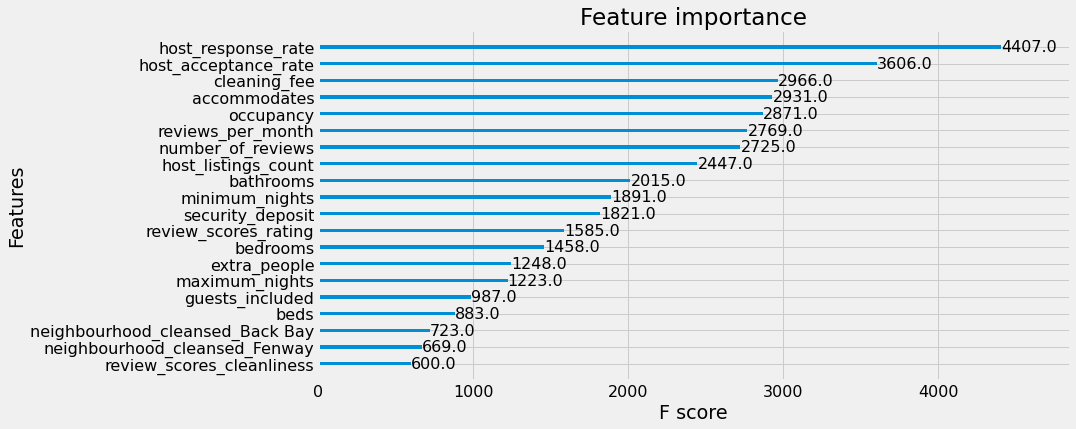

In [381]:
from xgboost import plot_importance
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(model, max_num_features=20, ax=ax)
plt.show();

Let's make shap analysis. As expected number of bedrooms (and bathrooms and number accomodatable people) corresponds well to price. Back Bay and Fenway area seems popular and add values to the properties. Also, the observation that properties with low occupacy rates have higher pricing is quite natural. TV and AC do not seem to affect pricing. 

In [384]:
import shap

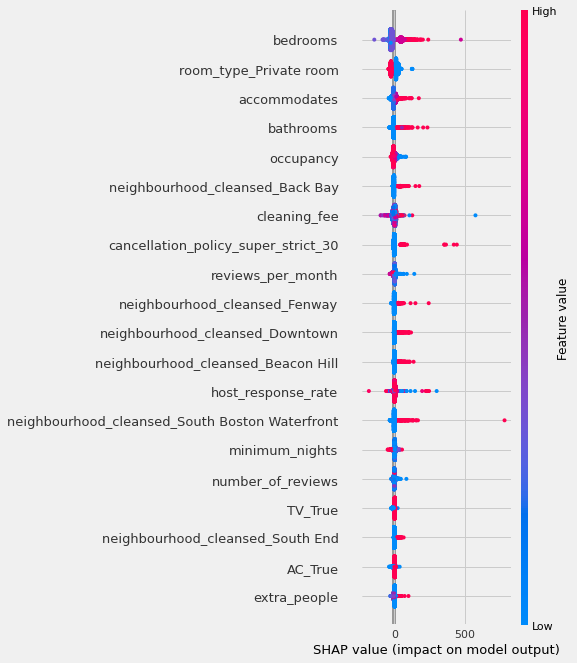

In [390]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)
#shap.plots.force(shap_values[0])